In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, Flatten, Dropout, MaxPooling3D, GlobalMaxPooling3D

from generators import VideoDataGenerator
from loader import get_classes

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Tensorflow Version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version:  2.1.0
Num GPUs Available:  1


In [3]:
data_dir = pathlib.Path("./data")
classes = get_classes(data_dir / "classes.txt")

params = {
    'color_mode': 'landmarks',
    'optical_flow': False,
    'batch_size': 8,
    'shuffle': True,
    'classes': classes
}

partition = {
    'train': list((data_dir / "Train").glob("**/*.mp4")),
    'test': list((data_dir / "Test").glob("**/*.mp4"))
}

training_generator = VideoDataGenerator(partition['train'], **params)
validation_generator = VideoDataGenerator(partition['test'], **params)

In [9]:
#model = Sequential([
#    Conv3D(16, (3, 7, 7), activation='relu', input_shape=(training_generator.dim)),
#    Conv3D(24, (3, 7, 7), activation='relu'),
#    MaxPooling3D((1, 3, 3)),
#    Conv3D(32, (3, 5, 7), activation='relu'),
#    Conv3D(64, (3, 5, 7), activation='relu'),
#    MaxPooling3D((1, 2, 2)),
#    Conv3D(128, (3, 3, 5), activation='relu'),
#    Conv3D(256, (3, 3, 5), activation='relu'),
#    Conv3D(512, (3, 3, 5), activation='relu'),
#    MaxPooling3D((1, 2, 2)),
#    Flatten(),
#    Dense(512, activation='relu'),
#    Dense(256, activation='relu'),
#    Dense(2, activation='softmax')
#])

model = Sequential([
    Conv3D(16, (4, 3, 3), activation='relu', input_shape=(training_generator.dim)),
    MaxPooling3D(),
    Conv3D(32, (3, 3, 3), activation='relu'),
    MaxPooling3D(),
    Conv3D(64, (1, 3, 3), activation='relu'),
    MaxPooling3D(),
    Flatten(),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 12, 148, 148, 16)  592       
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 6, 74, 74, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 4, 72, 72, 32)     13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 2, 36, 36, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 2, 34, 34, 64)     18496     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 1, 17, 17, 64)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18496)            

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(training_generator, validation_data=validation_generator, epochs=100, callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 233 steps, validate for 50 steps
Epoch 1/100
233/233 [==============================] - 24s 101ms/step - loss: 0.5852 - accuracy: 0.7044 - val_loss: 1.7452 - val_accuracy: 0.5125
Epoch 2/100
233/233 [==============================] - 22s 94ms/step - loss: 0.3386 - accuracy: 0.8691 - val_loss: 0.7315 - val_accuracy: 0.7225
Epoch 3/100
233/233 [==============================] - 22s 93ms/step - loss: 0.2964 - accuracy: 0.8868 - val_loss: 0.5541 - val_accuracy: 0.7400
Epoch 4/100
233/233 [==============================] - 22s 93ms/step - loss: 0.2429 - accuracy: 0.9093 - val_loss: 0.5392 - val_accuracy: 0.7850
Epoch 5/100
233/233 [==============================] - 22s 93ms/step - loss: 0.2260 - accuracy: 0.9061 - val_loss: 0.6475 - val_accuracy: 0.6950
Epoch 6/100
233/233 [==============================] - 22s 93ms/step - loss: 0.2311 - accuracy: 0.9179 - val_loss: 0.4124 - val_accuracy: 0.8475
Epoch 7/100
233/233 [===============

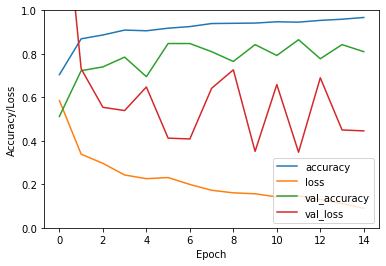

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
export_time = datetime.datetime.now()
export_path = pathlib.Path("export/model_{}-{}-{}-{}{}.h5".format(export_time.year, export_time.month, export_time.day, export_time.hour, export_time.minute))
print("Exporting trained model to {}".format(export_path.absolute()))

model.save(export_path)

Exporting trained model to d:\Dev\Projects\SpeechActionClassifier\export\model_2020-2-19-2230.h5
